In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from pyfermions import *

Helper to plot filters and their Fourier series:

In [2]:
def show_filters(**kwargs):
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    for label, s in kwargs.items():
        plt.plot(s.range, s.data, '-o', label=label)
    plt.axhline(0, ls='--', color='.5')
    plt.legend()

    plt.subplot(122)
    for label, s in kwargs.items():
        k = np.arange(-np.pi, np.pi, .01)
        S = s.ft(k)
        plt.plot(k, np.abs(S)**2, label=r'$|$%s$|^2$' % label)
    plt.xlim(0, np.pi)
    plt.legend()
    plt.show()

Helper to compare phase relation for wavelet sequences:

In [3]:
def show_phases(**kwargs):
    for label, m in kwargs.items():
        k = np.arange(-np.pi, np.pi, .01)
        H_w = m.h.wavelet_filter.ft(k)
        G_w = m.g.wavelet_filter.ft(k)
        plt.plot(
            k,
            np.angle(G_w / H_w),
            label=r'$\sphericalangle(G_w/H_w)$ %s' % label)
        plt.fill_between(
            k, 0, np.abs(H_w)**2, alpha=.6, label=r'$|G_w|^2$ %s' % label)
    plt.plot(
        k,
        np.angle(-1j * np.sign(k) * np.exp(1j * k / 2)),
        '--',
        label='ideal')
    plt.legend()
    plt.show()

# Glen's construction

Starting point are the Daubechies $D4$ wavelets, using the following convention for the wavelet filters:

In [4]:
q1 = DAUBECHIES_D4.wavelet_filter.reverse().shift(1)
q1

signal(array([-0.48296291,  0.8365163 , -0.22414387, -0.12940952]), start=0)

Construct corresponding qmf filter pair and show it:

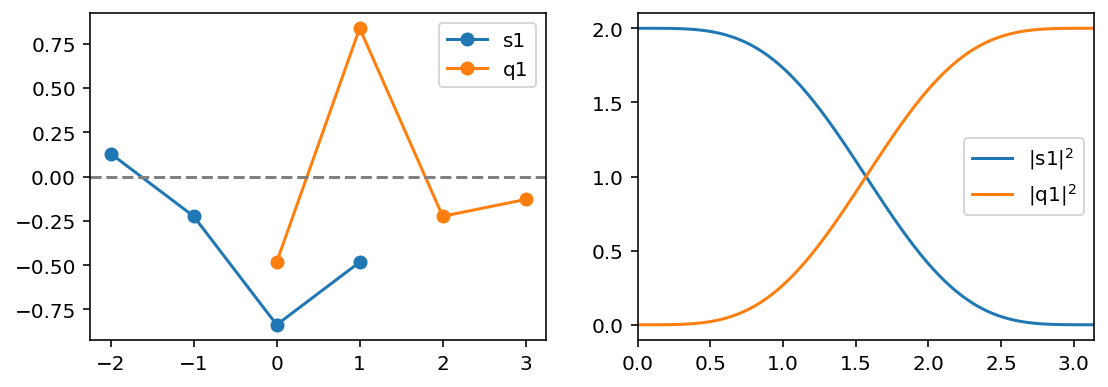

In [5]:
fp = orthogonal_wavelet.from_wavelet_filter(q1)
show_filters(s1=fp.scaling_filter, q1=fp.wavelet_filter)

Build "even" and "odd" wavelets (there is an overall minus sign, which is inconsequential but necessary to reproduce Figure 2):

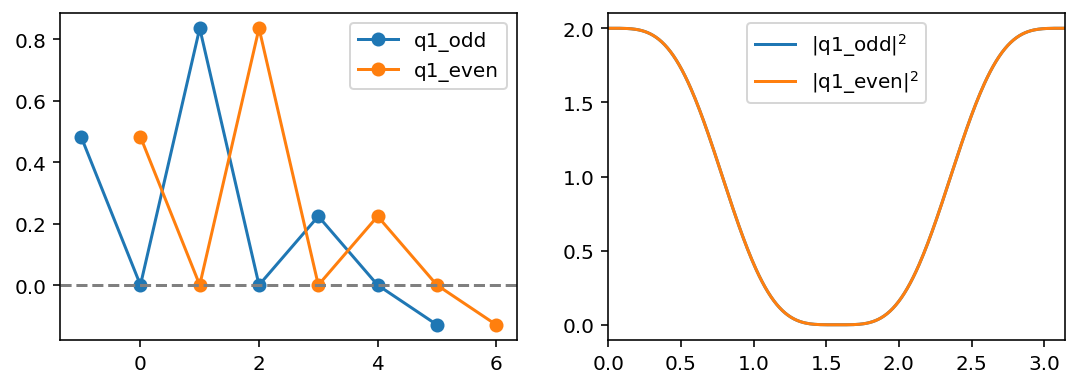

In [6]:
q1_odd = -q1.modulate(-1.).upsample().shift(-1)
q1_even = -q1.modulate(-1.).upsample()
show_filters(q1_odd=q1_odd, q1_even=q1_even)

These are the linear combinations that are approximately supported inside/outside the Fermi sea:

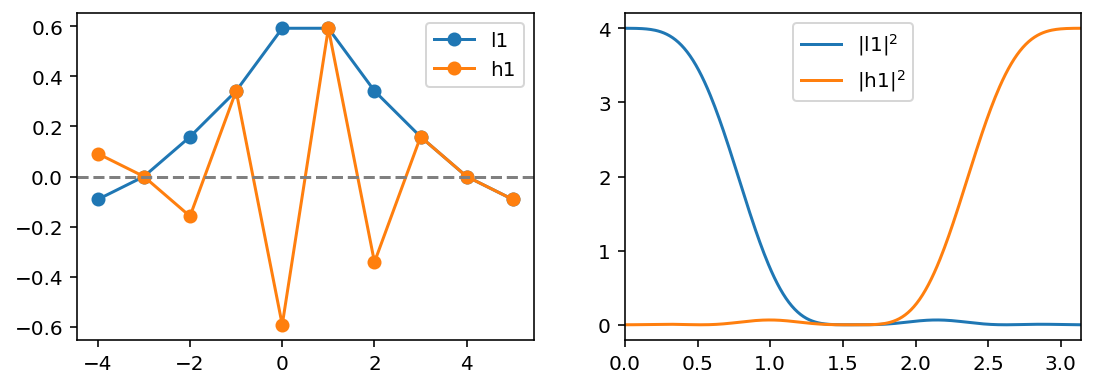

In [7]:
l1 = (q1_odd + q1_even.reverse().shift(2)) / np.sqrt(2)
h1 = (q1_odd - q1_even.reverse().shift(2)) / np.sqrt(2)
assert q1_even.reverse().shift(
    2
).start == q1_odd.start - 3, '"the support of an even wavelet starts three sites before that of an odd wavelet it is paired with"'
print()
show_filters(l1=l1, h1=h1)

NB: You might be concerned that the wavelet is supported on 10 taps. But this is not the case -- the second and second-to-last entry are always zero. It only seems that way because the even wavelet sequence starts 3 taps before the odd one (on the real lattice).

We would like to bring the above construction into our "normal form". That is, `l1` and `h1` should be obtained by only a Hadamard, and we want to follow the same upsampling-and-modulating convention as in `mera.eigenmode`.

This can be achieved as follows (note that the filters are shifted by one, which is inconsequential):

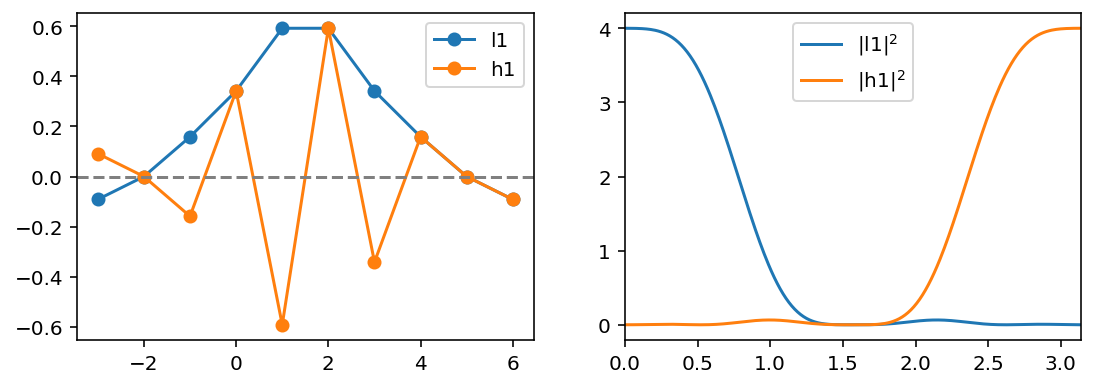

In [8]:
h_w = -q1
g_w = q1.reverse().shift(1)

a = h_w.modulate(-1.).upsample()
b = g_w.modulate(-1.).upsample().shift(1)
l1 = (a + b) / np.sqrt(2)
h1 = (a - b) / np.sqrt(2)
show_filters(l1=l1, h1=h1)

Just to confirm, let's do the same with our `qmf` and `mera` classes:

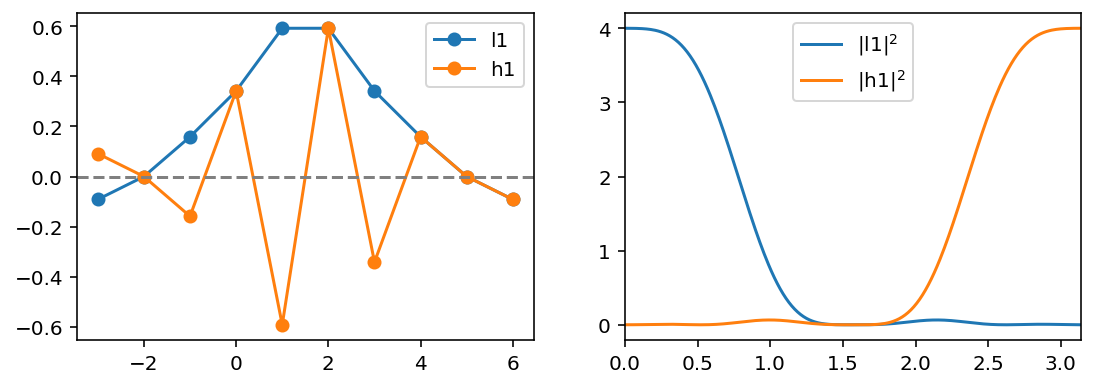

In [9]:
h = orthogonal_wavelet.from_wavelet_filter(h_w)
g = orthogonal_wavelet.from_wavelet_filter(g_w)

glen = mera1d(h, g)

l1 = glen.eigenmode(1)
h1 = glen.eigenmode(1, positive_energy=True)
show_filters(l1=l1, h1=h1)

For convience, let's display the numerical values of Glen's low-pass and high-pass filters:

In [10]:
print('h_s =', glen.h.scaling_filter)
print('g_s =', glen.g.scaling_filter)
print()
print('h_w =', glen.h.wavelet_filter)
print('g_w =', glen.g.wavelet_filter)

h_s = signal(array([-0.12940952,  0.22414387,  0.8365163 ,  0.48296291]), start=-2)
g_s = signal(array([ 0.48296291,  0.8365163 ,  0.22414387, -0.12940952]), start=0)

h_w = signal(array([ 0.48296291, -0.8365163 ,  0.22414387,  0.12940952]), start=0)
g_w = signal(array([-0.12940952, -0.22414387,  0.8365163 , -0.48296291]), start=-2)


Finally, compute the energy density using Glen's wavelets

In [11]:
E = glen.energy(levels=20)
E_expected = -2 / np.pi
(E_expected - E) / E_expected

0.0243550681489042

These are exactly the 2.4% mentioned in Table I in Glen's paper, so everything seems to be sane.

# Comparison with Selesnick K=L=1

Approximate negative eigenmodes:

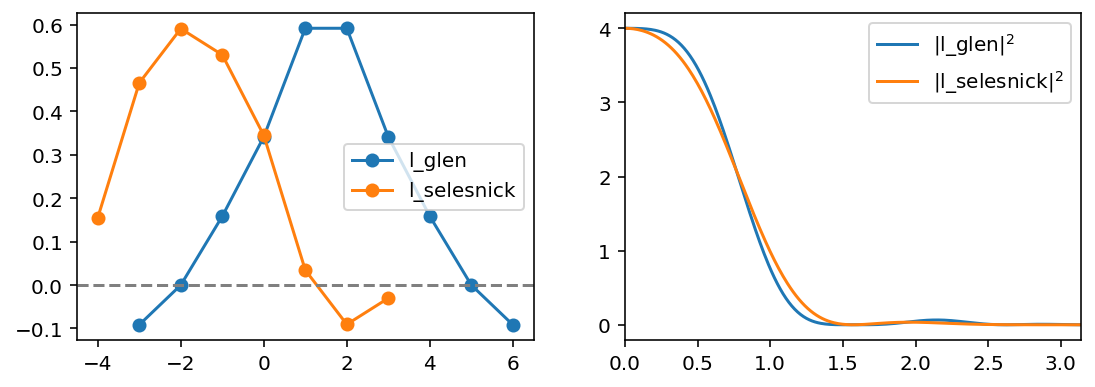

In [12]:
sel = mera1d.selesnick(1, 1)
show_filters(l_glen=l1, l_selesnick=sel.eigenmode(1))

The scaling filters:

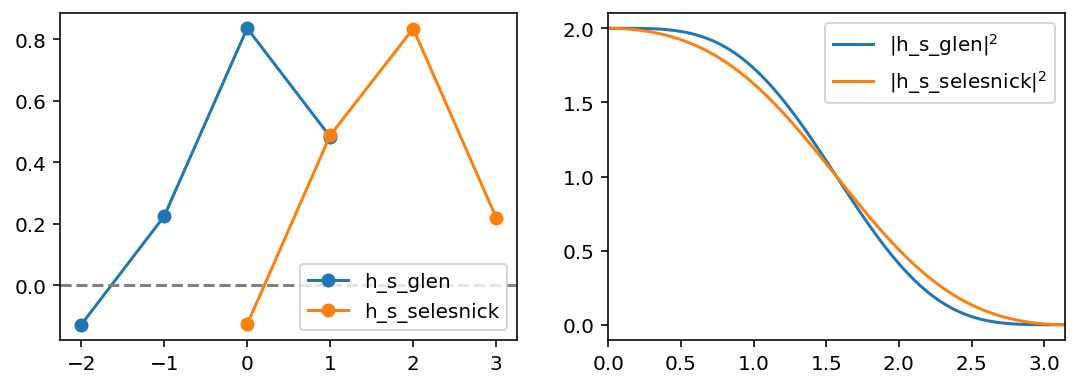

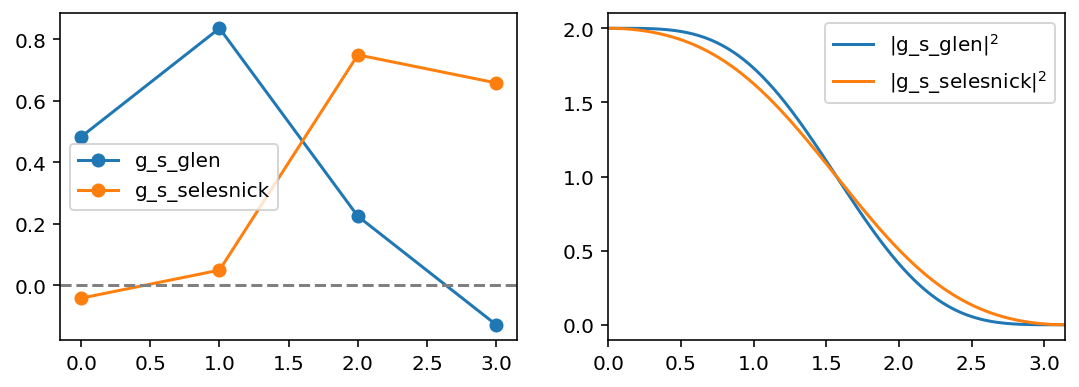

In [13]:
show_filters(
    h_s_glen=glen.h.scaling_filter, h_s_selesnick=sel.h.scaling_filter)
show_filters(
    g_s_glen=glen.g.scaling_filter, g_s_selesnick=sel.g.scaling_filter)

The wavelet filters:

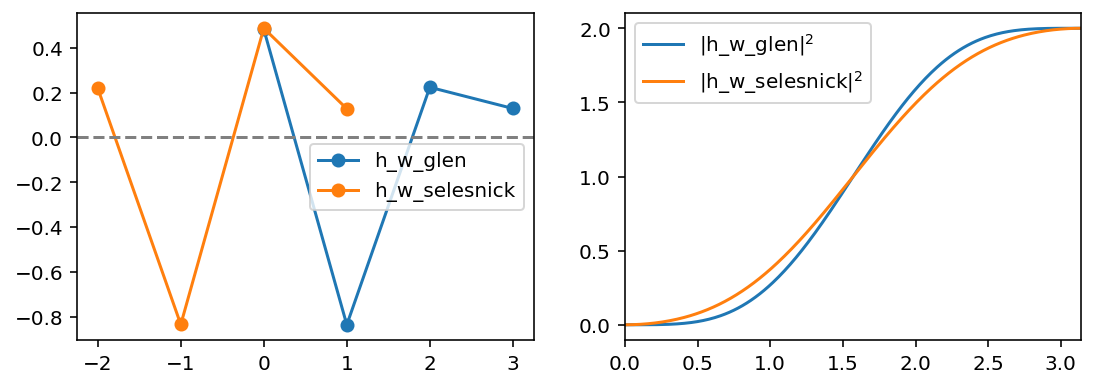

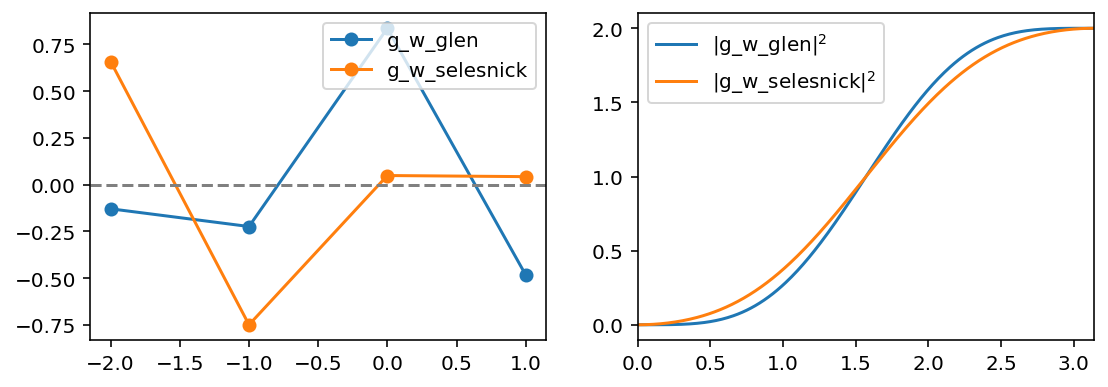

In [14]:
show_filters(
    h_w_glen=glen.h.wavelet_filter, h_w_selesnick=sel.h.wavelet_filter)
show_filters(
    g_w_glen=glen.g.wavelet_filter, g_w_selesnick=sel.g.wavelet_filter)

This is how well the wavelet filters satisfy the phase relation:

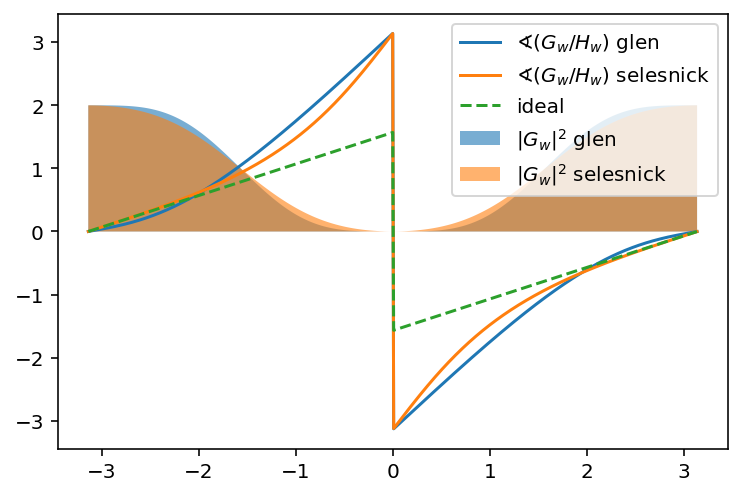

In [15]:
show_phases(glen=glen, selesnick=sel)

Again for convenience, let's display the scaling and wavelet filters for Selesnick's wavelets:

In [16]:
print('h_s =', sel.h.scaling_filter)
print('g_s =', sel.g.scaling_filter)
print()
print('h_w =', sel.h.wavelet_filter)
print('g_w =', sel.g.wavelet_filter)

h_s = signal(array([-0.12813828,  0.48761733,  0.83524506,  0.21948945]), start=0)
g_s = signal(array([-0.04271276,  0.04863842,  0.74981954,  0.65846836]), start=0)

h_w = signal(array([ 0.21948945, -0.83524506,  0.48761733,  0.12813828]), start=-2)
g_w = signal(array([ 0.65846836, -0.74981954,  0.04863842,  0.04271276]), start=-2)
